# W207 - Final Project
## Scott Abramson, Brett Brandom, Maria Jose Healey, Yidai Yao

### <span style="color:chocolate"> Pawpularity:predicting engagement with a pet's profile based on the photograph for that profile.  </span>

#### ``Objective``

This is based on a kaggle competition. The objective is to score pet photos on a "Cuteness Meter" so that pets up for adoption have a higher chance of being adopted.

#### ``Introduction``

TBD

#### ``Data``

Dataset downloaded from Kaggle competition.

### Step 1: Import libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import train_test_split

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

IMAGE_PATH = '/users/scottabramson/MIDS_LOCAL_DATA/pawpularity_data/train/'
LABEL_PATH = '/users/scottabramson/MIDS_LOCAL_DATA/pawpularity_data/'

### Step 2: Read Data

In [2]:
# read meta_data
meta_data = pd.read_csv(
    LABEL_PATH + 'train.csv'
)

print('Shape of Meta Data:', meta_data.shape)
meta_data.head()

Shape of Meta Data: (9912, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


count    9912.000000
mean       38.039044
std        20.591990
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64

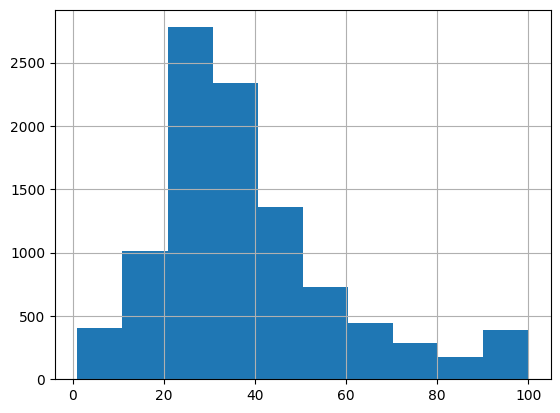

In [3]:
# Look at the distribution of labels from 0 - 100
meta_data['Pawpularity'].hist()
meta_data['Pawpularity'].describe()



In [4]:
meta_data['Pawpularity'].value_counts().sort_values()

Pawpularity
99      4
1       4
90      7
97      8
98     10
     ... 
29    304
31    312
26    316
30    318
28    318
Name: count, Length: 100, dtype: int64

In [5]:
# Check the ends of the distribution
print("Count of Pawpularity Scores of 1: ",meta_data['Pawpularity'].value_counts()[1])
print("Count of Pawpularity Scores of 1: ",meta_data['Pawpularity'].value_counts()[100])

Count of Pawpularity Scores of 1:  4
Count of Pawpularity Scores of 1:  288


In [6]:
# Evaluate the distribution of meta data values for all images
label_metadata = meta_data
label_metadata['Meta_Sum'] = label_metadata.iloc[:, -12:-2].sum(axis=1)
label_metadata.sort_values(by='Meta_Sum')
print("Distribution of Meta Data Sums per Image\n",label_metadata['Meta_Sum'].value_counts())
label_metadata.head()

totals = []
counts = []
for i in range(8) :
    totals.append(label_metadata.loc[label_metadata['Meta_Sum'] == i, 'Pawpularity'].sum())
    counts.append(label_metadata['Meta_Sum'].value_counts()[i])
    print("Meta Sum :", i, "Count :", counts[i], "Pawpularity Sum :", totals[i], "Average :", totals[i]/counts[i])



Distribution of Meta Data Sums per Image
 Meta_Sum
3    4763
4    1718
2    1319
5    1130
1     656
6     197
0      76
7      48
8       5
Name: count, dtype: int64
Meta Sum : 0 Count : 76 Pawpularity Sum : 2465 Average : 32.43421052631579
Meta Sum : 1 Count : 656 Pawpularity Sum : 25040 Average : 38.170731707317074
Meta Sum : 2 Count : 1319 Pawpularity Sum : 49651 Average : 37.642911296436694
Meta Sum : 3 Count : 4763 Pawpularity Sum : 181592 Average : 38.12555112324166
Meta Sum : 4 Count : 1718 Pawpularity Sum : 65965 Average : 38.39639115250291
Meta Sum : 5 Count : 1130 Pawpularity Sum : 42760 Average : 37.84070796460177
Meta Sum : 6 Count : 197 Pawpularity Sum : 7454 Average : 37.83756345177665
Meta Sum : 7 Count : 48 Pawpularity Sum : 1937 Average : 40.354166666666664


### Step 3: EDA

### EDA

It's pretty clear that there will be variance in the size, orientation and possibly the resolution of the photos.

### Step 4: Preprocess Data

In [7]:
# Class with class variables we can access throughout
class CF :
    image_size = [224, 224]
    augm_flag = False
    bright_delta = 0.5
#    contrast = 20
    flip_lr_flag = False
    flip_ud_flag = False
    def __repr__(self):
        config_string = "\n image_size : " + ' '.join(str(size) for size in self.image_size)
        config_string += "\n augm_flag : " + str(self.augm_flag)
        config_string += "\n bright_delta : " + str(self.bright_delta)
#        config_string += "\n contrast : " + str(self.contrast)
        config_string += "\n flip_lr_flag : " + str(self.flip_lr_flag)
        config_string += "\n flip_ud_flag : " + str(self.flip_ud_flag)
        return config_string


In [8]:
def process_file_names(file_name, label):
    image_string = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(image_string, channels=3)
    img = tf.image.resize(img, CF.image_size)
    
    if CF.augm_flag :
        # Adjust Brightness to a copy of the images
        img_augm = tf.image.adjust_brightness(img, delta = CF.bright_delta)
    
        # adjust contrast to the copy
        #img_augm = tf.image.adjust_contrast(img_augm, CF.contrast)
    
        # random flip the copy left / right
        if CF.flip_lr_flag == True :
            img_augm = tf.image.random_flip_left_right(img_augm)
        
        # random flip the copy up / down
        if CF.flip_ud_flag == True :
            img_augm = tf.image.random_flip_up_down(img_augm)
        
        
        # Concatenate the augmented images with the original images
        # Keep the labels the same
        img = tf.concat([img, img_augm], axis=1)
        label_augm = label
        label = tf.stack([label, label_augm], axis=0)

    # rescale labels so between 0 and 1
    return img, label/100.01


In [9]:
def process_file_names_augm(file_name, label):
    image_string = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(image_string, channels=3)
    img = tf.image.resize(img, CF.image_size)


    # Adjust Brightness to a copy of the images
    img = tf.image.adjust_brightness(img, delta = CF.bright_delta)

    # adjust contrast to the copy
    img = tf.image.adjust_contrast(img, 20)
    print("adjust")

    # random flip the copy left / right
    if CF.flip_lr_flag == True :
        img = tf.image.random_flip_left_right(img)
    
    # random flip the copy up / down
    if CF.flip_ud_flag == True :
        img = tf.image.random_flip_up_down(img)
    
    # rescale labels so between 0 and 1
    return img, label/100.01


In [10]:
def prepare_data(image_path, label_path) :

    train_images = os.listdir(image_path)
    train_df = pd.read_csv(label_path + 'train.csv')

    train_df = train_df.set_index('Id')
    file_names = []
    labels = []

    for index in train_df.index:
        file_name = image_path + index + '.jpg'
        label = train_df.loc[index]['Pawpularity']
        file_names.append(file_name)
        labels.append(label/1.0)

    # Use sklearn function to split data
    train_files, val_files, labels_train, labels_val = train_test_split(file_names, labels, test_size=0.2, random_state=137)
    
    return train_files, val_files, labels_train, labels_val


In [11]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(32)
    return ds

In [12]:
# Prepare the data
train_files, val_files, labels_train, labels_val = prepare_data(IMAGE_PATH, LABEL_PATH)

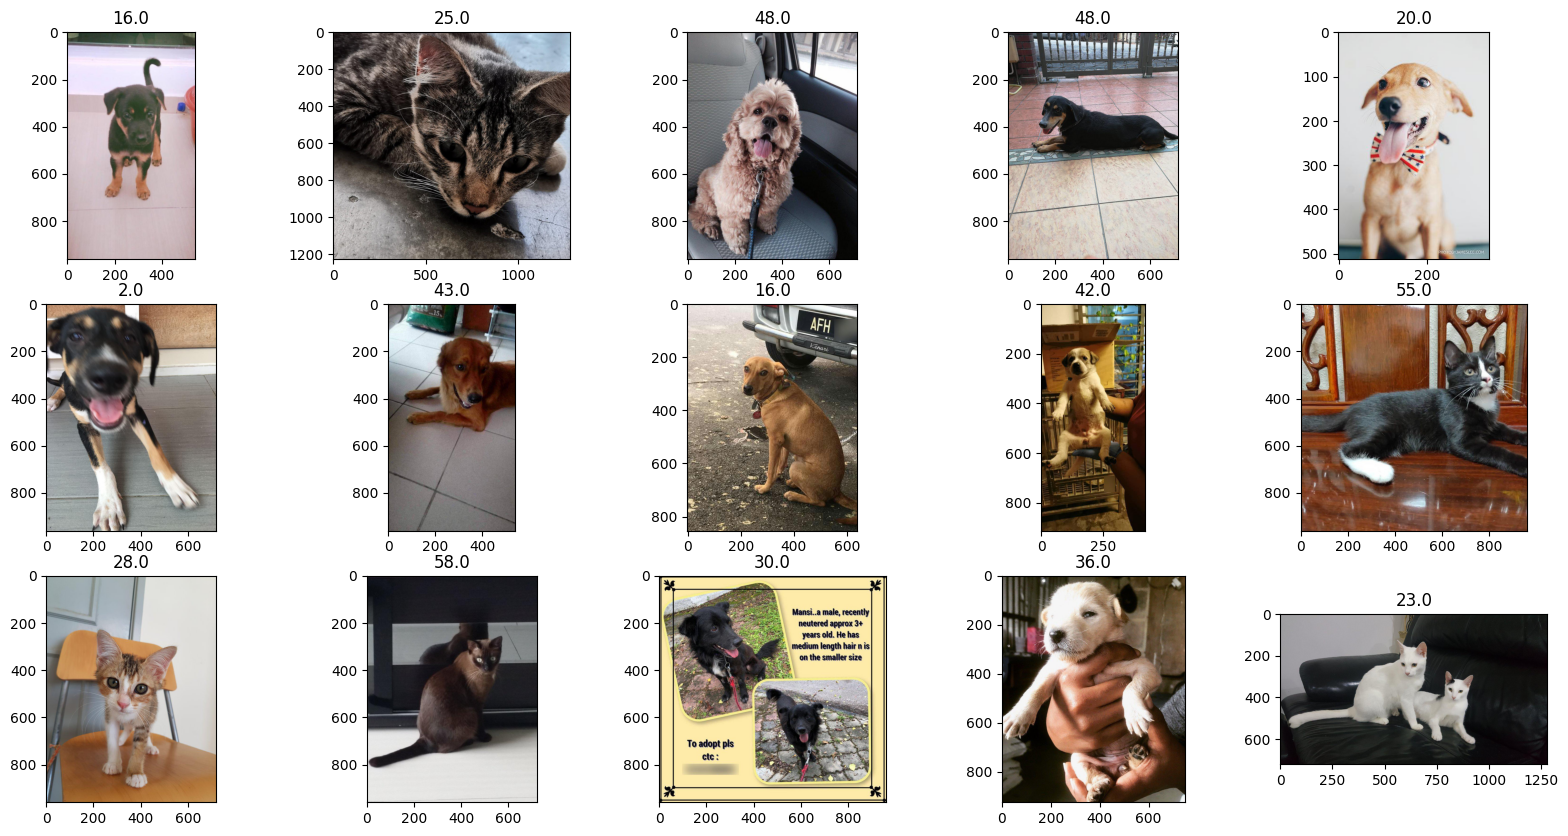

In [13]:
# Show some of the original images, unmodified
nrows, ncols = 3,5
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*ncols+j
        axs[i,j].imshow(load_img(val_files[indx]))
        axs[i,j].set(title=labels_val[indx])


In [14]:
def prepare_datasets(train_files, val_files, labels_train, labels_val) :
    
    # Create the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_files, labels_train))
   
    # Run the mapping function on the taining dataset
    train_dataset = train_dataset.map(process_file_names)
    
    # Create and run the mapping on the validation data set
    val_dataset = tf.data.Dataset.from_tensor_slices((val_files, labels_val))
    val_dataset = val_dataset.map(process_file_names)
    
    # Configure for performance on large dataset
    train_dataset = configure_for_performance(train_dataset)
    val_dataset = configure_for_performance(val_dataset)

    return train_dataset, val_dataset


In [15]:
def prepare_datasets_augm(train_files, val_files, labels_train, labels_val) :
    # Create the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_files, labels_train))
    train_augm_dataset = tf.data.Dataset.from_tensor_slices((train_files, labels_train))

    CF.augm_flag = False
    train_dataset = train_dataset.map(process_file_names)

    CF.augm_flag = True
    train_augm_dataset = train_augm_dataset.map(process_file_names_augm)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_files, labels_val))
    val_augm_dataset = tf.data.Dataset.from_tensor_slices((val_files, labels_val))

    CF.augm_flag = False
    val_dataset = val_dataset.map(process_file_names)
    
    CF.augm_flag = True
    val_augm_dataset = val_augm_dataset.map(process_file_names_augm)

    train_ds = tf.data.Dataset.zip((train_dataset, train_augm_dataset))
    val_ds = tf.data.Dataset.zip((val_dataset, val_augm_dataset))
    
    # Configure for performance on large dataset
    train_ds = configure_for_performance(train_ds)
    val_ds = configure_for_performance(val_ds)

    return train_ds, val_ds


In [16]:
# Perform some additional image manipulation
CF.augm_flag = True
CF.flip_lr_flag = True

In [17]:
# Print the current configuration modifications on the originals
print(CF().__repr__())


 image_size : 224 224
 augm_flag : True
 bright_delta : 0.5
 flip_lr_flag : True
 flip_ud_flag : False


In [18]:
train_dataset, val_dataset = prepare_datasets_augm(train_files, val_files, labels_train, labels_val)
train_dataset

adjust
adjust


<_BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None)), (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None)))>

In [19]:
# Show the modified images in the batch data set

def show_tfbatch_images(dataset) :
    
    for images, labels in dataset.take(1):  # only take first element of dataset
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()

    nrows, ncols = 3,5 #print first 8 images
    f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
    for i in range(nrows):
        for j in range(ncols):
            indx = i*ncols+j
            axs[i,j].imshow(array_to_img(numpy_images[indx]))
            axs[i,j].set(title=numpy_labels[indx])
    return


In [20]:
show_tfbatch_images(val_dataset)

2024-04-01 18:56:52.318526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1983]
	 [[{{node Placeholder/_1}}]]
2024-04-01 18:56:52.319596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [1983]
	 [[{{node Placeholder/_4}}]]
2024-04-01 18:56:52.343228: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-01 18:56:56.865592: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation o

AttributeError: 'tuple' object has no attribute 'numpy'

### Step 5: Modeling and Evaluation

### <span style="color:chocolate"> Baseline Model  </span>

In [ ]:
def make_model(ksize=[5,5], ssize=[1,1], psize=[2,2]) :

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(ksize[0], ksize[1]),
        strides=(ssize[0], ssize[1]),
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))

    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(psize[0],psize[1]),
        name='pool_1'))


    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(ksize[0], ksize[1]),
        strides=(ssize[0], ssize[1]),
        padding='same',
        name='conv_2',
        activation='relu'))

    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(psize[0], psize[1]), name='pool_2')
    )


    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))
    
    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_2',
        activation=None))

    return model


In [ ]:
# Make Model with Defaults
model = make_model()

# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 224, 224, 3))
model.summary()

In [ ]:
def compile_model(model, optimizer='Adam', learning_rate=0.001) :
    if optimizer == 'Adam' :
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 
    elif optimizer == 'SGD' :
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

    return model

In [ ]:
# Compile model with defaults
model = compile_model(model)

In [ ]:
# Fit model with defaults
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(train_dataset, )

### <span style="color:chocolate"> Improvement on Baseline Model  </span>

### Step 6: Conclusion

TBD